In [1]:
!pip install sacrebleu
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7f830fea30507652349e8cca58211b34496516c23ad6d241f723e779de4a3d0e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import math
from dataclasses import dataclass
import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import os
from pathlib import Path

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

SRC = "en"
TRG = "ur"

# Function to read UMC005 dataset
def read_umc005_data(src_file, trg_file):
    with open(src_file, 'r', encoding='utf-8') as f_src, open(trg_file, 'r', encoding='utf-8') as f_trg:
        src_lines = f_src.readlines()
        trg_lines = f_trg.readlines()
    return list(zip([line.strip() for line in src_lines], [line.strip() for line in trg_lines]))

# Load UMC005 dataset
train_src = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/train.en"
train_trg = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/train.ur"
valid_src = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/dev.en"
valid_trg = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/dev.ur"
test_src = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/test.en"
test_trg = "/kaggle/input/umc005-english-urdu-parallel-corpus/bible/test.ur"

train_set = read_umc005_data(train_src, train_trg)
valid_set = read_umc005_data(valid_src, valid_trg)
test_set = read_umc005_data(test_src, test_trg)

# Save text files for SentencePiece training
with open("/kaggle/working/UMC005_ur_text.txt", "w", encoding='utf-8') as f_ur:
    for pair in train_set:
        f_ur.write(pair[1] + '\n')

with open("/kaggle/working/UMC005_en_text.txt", "w", encoding='utf-8') as f_en:
    for pair in train_set:
        f_en.write(pair[0] + '\n')

# Adjust vocabulary sizes for smaller dataset
ur_vocab_size = 3000  
en_vocab_size = 4000
vocab_sizes = {"en": en_vocab_size, "ur": ur_vocab_size}

# Train SentencePiece models
spm.SentencePieceTrainer.train(
    f'--input=/kaggle/working/UMC005_ur_text.txt --model_prefix=UMC005_ur --character_coverage=1.0 --user_defined_symbols= --vocab_size={ur_vocab_size}')
spm.SentencePieceTrainer.train(
    f'--input=/kaggle/working/UMC005_en_text.txt --model_prefix=UMC005_en --character_coverage=1.0 --user_defined_symbols= --vocab_size={en_vocab_size}')


# Load SentencePiece models
ur_sp = spm.SentencePieceProcessor()
ur_sp.load('/kaggle/working/UMC005_ur.model')
en_sp = spm.SentencePieceProcessor()
en_sp.load('/kaggle/working/UMC005_en.model')

tokenizers = {"en": en_sp.encode_as_ids, "ur": ur_sp.encode_as_ids}
detokenizers = {"en": en_sp.decode_ids, "ur": ur_sp.decode_ids}

# Special tokens
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Adjust maximum sequence length for Urdu-English translation
max_seq_len = 100  # High as religious texts might have longer sentences

def tokenize_dataset(dataset):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
             torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
            for src_text, trg_text in dataset]

train_tokenized = tokenize_dataset(train_set)
valid_tokenized = tokenize_dataset(valid_set)
test_tokenized = tokenize_dataset(test_set)

cuda


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/kaggle/working/UMC005_ur_text.txt --model_prefix=UMC005_ur --character_coverage=1.0 --user_defined_symbols= --vocab_size=3000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/working/UMC005_ur_text.txt
  input_format: 
  model_prefix: UMC005_ur
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def pad_sequence(batch):
    src_seqs = [src for src, trg in batch]
    trg_seqs = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs, batch_first=True, padding_value=PAD)
    return src_padded, trg_padded

batch_size = 32  # Reduced due to smaller dataset

class Dataloaders:
    def __init__(self):
        self.train_dataset = TranslationDataset(train_tokenized)
        self.valid_dataset = TranslationDataset(valid_tokenized)
        self.test_dataset = TranslationDataset(test_tokenized)
        
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)
        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)
        self.valid_loader = torch.utils.data.DataLoader(
            self.valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence)



In [4]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)
        # Store attention weights for visualization
        self.attention_weights = None

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0)
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        
        # Store attention weights for visualization
        self.attention_weights = F.softmax(scores, dim=-1)
        p_atten = self.dropout(self.attention_weights)
        
        x = torch.matmul(p_atten, value)
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x)

def visualize_attention(model, src_sentence, trg_sentence, tokenizers, device=DEVICE):
    """
    Visualize attention weights for a given source and target sentence pair
    """
    # Tokenize input sentences
    src_tokens = [en_sp.decode_pieces([en_sp.id_to_piece(id)]) for id in tokenizers["en"](src_sentence)]
    trg_tokens = [ur_sp.decode_pieces([ur_sp.id_to_piece(id)]) for id in tokenizers["ur"](trg_sentence)]
    
    # Prepare input tensors
    src_ids = torch.tensor([[BOS] + tokenizers["en"](src_sentence) + [EOS]]).to(device)
    trg_ids = torch.tensor([[BOS] + tokenizers["ur"](trg_sentence) + [EOS]]).to(device)
    
    # Create masks
    src_pad_mask = (src_ids == PAD).unsqueeze(1).unsqueeze(2)
    trg_pad_mask = (trg_ids == PAD).unsqueeze(1).unsqueeze(2)
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        # Get encoder output and store attention weights
        encoder_output = model.encoder(src_ids, src_pad_mask)
        decoder_output = model.decoder(encoder_output, src_pad_mask, trg_ids, trg_pad_mask)
        
        # Get attention weights from the last decoder layer
        attention_weights = model.decoder.decoder_blocks[-1].atten2.attention_weights[0]  # Get weights for first batch
        
        # Average attention weights across heads
        attention_weights = attention_weights.mean(dim=0).cpu().numpy()
    
    # Create attention visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_weights[:len(trg_tokens), :len(src_tokens)],
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis',
                square=True)
    plt.xlabel('English Words')
    plt.ylabel('Urdu Words')
    plt.title('Attention Weights Visualization')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    return plt

def translate_with_attention(model, sentence, tokenizers, max_len=50, device=DEVICE):
    """
    Translate a sentence and return both translation and attention weights
    """
    model.eval()
    src_ids = torch.tensor([[BOS] + tokenizers["en"](sentence) + [EOS]]).to(device)
    src_pad_mask = (src_ids == PAD).unsqueeze(1).unsqueeze(2)
    
    with torch.no_grad():
        encoder_output = model.encoder(src_ids, src_pad_mask)
        
        # Initialize target sequence with BOS token
        trg_ids = torch.tensor([[BOS]]).to(device)
        
        for _ in range(max_len):
            trg_pad_mask = (trg_ids == PAD).unsqueeze(1).unsqueeze(2)
            output = model.decoder(encoder_output, src_pad_mask, trg_ids, trg_pad_mask)
            next_token = output[:, -1:].argmax(dim=-1)
            trg_ids = torch.cat([trg_ids, next_token], dim=1)
            
            if next_token.item() == EOS:
                break
        
        # Get attention weights from the last layer
        attention_weights = model.decoder.decoder_blocks[-1].atten2.attention_weights[0]
        
    # Decode the translation
    translation = detokenizers["ur"](trg_ids[0].cpu().tolist()[1:-1])
    return translation, attention_weights.mean(dim=0).cpu().numpy()


class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))


class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)
     


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

In [10]:
# Modified training configuration
config = ModelConfig(
    encoder_vocab_size=vocab_sizes[SRC],
    decoder_vocab_size=vocab_sizes[TRG],
    d_embed=256,  
    d_ff=512,
    h=8,
    N_encoder=3,
    N_decoder=3,
    max_seq_len=max_seq_len,
    dropout=0.2  # Increased dropout for better regularization with small dataset
)

# Modified training parameters
warmup_steps = 4 * len(Dataloaders().train_loader)  # Adjusted for smaller dataset
early_stop_count = 3  # Increased patience for smaller dataset

In [11]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask
     

from numpy.lib.utils import lookfor
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        # report progress
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs):
    global early_stop_count
    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader) * batch_size
    
    try:
        for ep in range(epochs):
            train_loss = train_epoch(model, dataloaders)
            valid_loss = validate(model, dataloaders.valid_loader)
            
            print(f'Epoch {ep + 1}/{epochs}:')
            print(f'Train Loss: {train_loss:.5f}')
            print(f'Valid Loss: {valid_loss:.5f}')
            
            # Save model checkpoint
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save({
                    'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'valid_loss': valid_loss,
                }, 'best_model_checkpoint.pt')
            else:
                if scheduler.last_epoch > 2 * warmup_steps:
                    early_stop_count -= 1
                    print(f'Early stopping counter: {early_stop_count}')
                    if early_stop_count <= 0:
                        print('Early stopping triggered')
                        break
            
            print('-' * 50)
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None, None
    
    return train_loss, valid_loss
      
               
def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)
     

def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        try:
            dB = x.size(0)
            y = torch.tensor([[BOS] * dB]).view(dB, 1).to(DEVICE)
            x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
            memory = model.encoder(x, x_pad_mask)
            
            for i in range(max_seq_len):
                y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
                logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
                last_output = logits.argmax(-1)[:, -1]
                last_output = last_output.view(dB, 1)
                y = torch.cat((y, last_output), 1).to(DEVICE)
                
                # Stop if all sequences have generated EOS token
                if ((y == EOS).sum(dim=1) > 0).all():
                    break
            
            return y
        except Exception as e:
            print(f"Error in translation: {str(e)}")
            return torch.tensor([[BOS, EOS]]).to(DEVICE)
     

def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    try:
        return detokenizer(sentence_ids).replace("", "").replace("", "").strip().replace(" .", ".")
    except:
        return ""  # Return empty string if decoding fails


def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans = [], []
    example_count = 0
    max_examples = 3  # Number of examples to print
    printed_examples = 0
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            if num_batch and idx >= num_batch:
                break
                
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            
            batch_size = len(src)
            for i in range(batch_size):
                refs.append(decode_sentence(detokenizers[TRG], trg_out[i]))
                cans.append(decode_sentence(detokenizers[TRG], translation[i]))
                
                # Print examples only if we haven't printed enough yet
                if printed_examples < max_examples:
                    try:
                        print(f'Example {printed_examples + 1}:')
                        print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
                        print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
                        print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
                        print('-' * 50)
                        printed_examples += 1
                    except Exception as e:
                        print(f"Error printing example: {str(e)}")
                        continue
            
            example_count += batch_size
    
    # Compute BLEU score
    try:
        bleu_score = sacrebleu.corpus_bleu(cans, [refs]).score
    except Exception as e:
        print(f"Error computing BLEU score: {str(e)}")
        bleu_score = 0.0
    
    print(f"Evaluated {example_count} examples")
    return bleu_score
     


In [12]:
data_loaders = Dataloaders()
train_size = len(data_loaders.train_loader)*batch_size
model = make_model(config)
model_size = sum([p.numel() for p in model.parameters()])
print(f'Model size: {model_size:,} parameters')
print(f'Training set size: {train_size:,} samples')
warmup_steps = 3*len(data_loaders.train_loader)
lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
early_stop_count = 2
train_loss, valid_loss = train(model, data_loaders, epochs=15)
test_loss  = validate(model, data_loaders.test_loader)

print("train set examples:")
train_bleu = evaluate(model, data_loaders.train_loader, 20)
print("validation set examples:")
valid_bleu = evaluate(model, data_loaders.valid_loader)
print("test set examples:")
test_bleu  = evaluate(model, data_loaders.test_loader)
print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')
torch.save(model.state_dict(), 'final_model.pt')

Model size: 6,568,888 parameters
Training set size: 7,424 samples


train loss=4.846, lr=0.00034: 100%|██████████| 232/232 [00:07<00:00, 31.80it/s]


Epoch 1/15:
Train Loss: 6.01667
Valid Loss: 4.71377
--------------------------------------------------


train loss=4.042, lr=0.00074: 100%|██████████| 232/232 [00:06<00:00, 33.90it/s]


Epoch 2/15:
Train Loss: 4.25581
Valid Loss: 4.02560
--------------------------------------------------


train loss=3.571, lr=0.00113: 100%|██████████| 232/232 [00:06<00:00, 34.53it/s]


Epoch 3/15:
Train Loss: 3.69276
Valid Loss: 3.72622
--------------------------------------------------


train loss=3.110, lr=0.00104: 100%|██████████| 232/232 [00:07<00:00, 32.95it/s]


Epoch 4/15:
Train Loss: 3.30319
Valid Loss: 3.51672
--------------------------------------------------


train loss=2.892, lr=0.00093: 100%|██████████| 232/232 [00:06<00:00, 33.84it/s]


Epoch 5/15:
Train Loss: 2.98384
Valid Loss: 3.35408
--------------------------------------------------


train loss=2.841, lr=0.00085: 100%|██████████| 232/232 [00:06<00:00, 33.32it/s]


Epoch 6/15:
Train Loss: 2.74480
Valid Loss: 3.26792
--------------------------------------------------


train loss=2.663, lr=0.00078: 100%|██████████| 232/232 [00:06<00:00, 34.57it/s]


Epoch 7/15:
Train Loss: 2.56021
Valid Loss: 3.21527
--------------------------------------------------


train loss=2.355, lr=0.00073: 100%|██████████| 232/232 [00:06<00:00, 34.21it/s]


Epoch 8/15:
Train Loss: 2.40832
Valid Loss: 3.21977
Early stopping counter: 1
--------------------------------------------------


train loss=2.248, lr=0.00069: 100%|██████████| 232/232 [00:06<00:00, 33.16it/s]


Epoch 9/15:
Train Loss: 2.27528
Valid Loss: 3.17913
--------------------------------------------------


train loss=2.290, lr=0.00065: 100%|██████████| 232/232 [00:06<00:00, 34.43it/s]


Epoch 10/15:
Train Loss: 2.16870
Valid Loss: 3.21625
Early stopping counter: 0
Early stopping triggered
train set examples:
Example 1:
src:  But and if that servant say in his heart , My lord delayeth his coming ; and shall begin to beat the menservants and maidens , and to eat and drink , and to be drunken.
trg:  لیکن اگر وہ نوکر اپنے دل میں یہ کہہ کر کہ میرے مالک کے آنے میں دیر ہے غلاموں اور لونڈیوں کو مارنا اور کھا پی کر متوالا ہونا شروع کرے ۔
pred: لیکن اگر وہ اپنی مرضی کے مالک کی مانند ہے تو میری مانند ہے اور اس کے پاس آکر کہا کہ یہاں گوشت اور قتل کریں گوشت اور قتل کریں گوشت کھاو ۔
--------------------------------------------------
Example 2:
src:  Notwithstanding the Lord stood with me , and strengthened me ; that by me the preaching might be fully known , and that all the Gentiles might hear : and I was delivered out of the mouth of the lion.
trg:  مگر خداوند میرا مددگار تھا اور اس نے مجھے طاقت بخشی تاکہ میری معرفت پیغام کی پوری منادی ہو جائے اور سب غیرقومویں سن لیں ۔ اور میں شی


Output: جو باتیں ان سے کہا میں نے یہ باتیں اب تک آکر یسوع کے پاس آکر کہا اے خداوند ! میں بھی اب تک قائم رہو ۔


/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 1748 (\N{ARABIC FULL STOP}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, 

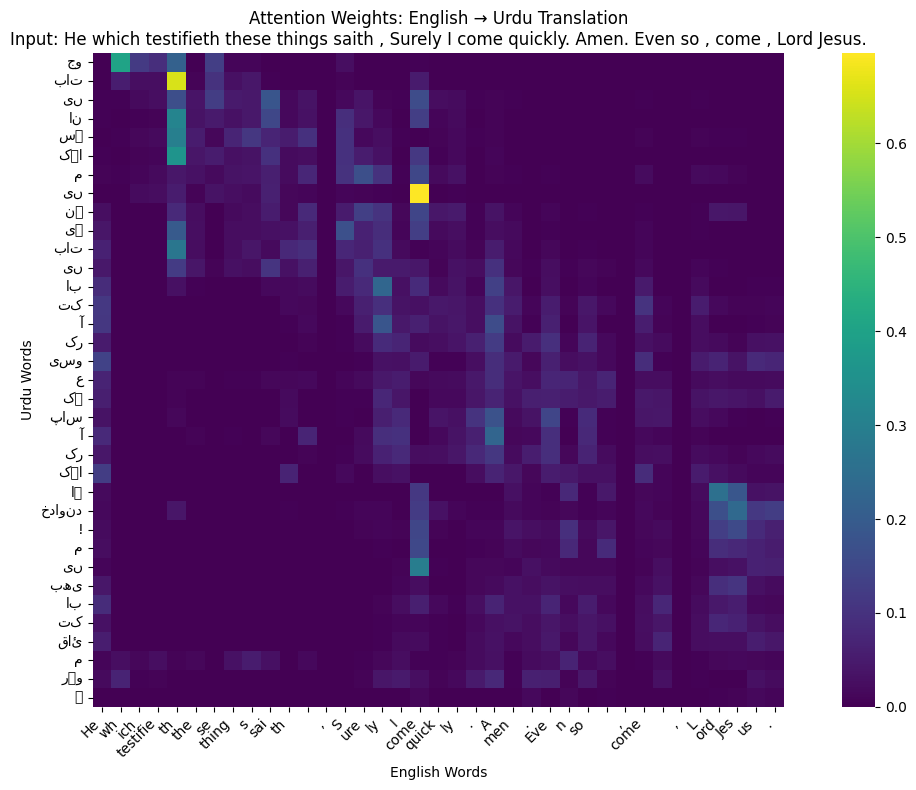

In [16]:
def demo_attention(model, sentence):
    """
    Demonstrate attention visualization for a given sentence
    """
    translation, attention_weights = translate_with_attention(model, sentence, tokenizers)
    
    # Get tokens
    src_tokens = [en_sp.decode_pieces([en_sp.id_to_piece(id)]) for id in tokenizers["en"](sentence)]
    trg_tokens = [ur_sp.decode_pieces([ur_sp.id_to_piece(id)]) for id in tokenizers["ur"](translation)]

    print(f"\nOutput: {translation}")
    # Visualize attention
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_weights[:len(trg_tokens), :len(src_tokens)],
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis',
                square=True)
    plt.xlabel('English Words')
    plt.ylabel('Urdu Words')
    plt.title(f'Attention Weights: English → Urdu Translation\nInput: {sentence}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    return plt

sentence = "He which testifieth these things saith , Surely I come quickly. Amen. Even so , come , Lord Jesus."
demo_attention(model, sentence)
plt.show()

In [17]:
def translate_this_sentence(text: str):
    'translate the Urdu sentence into English'
    input = torch.tensor([[BOS] + tokenizers[SRC](text) + [EOS]]).to(DEVICE)
    output = translate(model, input)
    return decode_sentence(detokenizers[TRG], output[0])

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# Define LSTM Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, cell):
        trg = trg.unsqueeze(1)  # Add batch dimension
        embedded = self.dropout(self.embedding(trg))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

# Define Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.size(1)
        batch_size = trg.size(0)
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        
        trg_token = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(trg_token, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            trg_token = trg[:, t] if teacher_force else top1
        return outputs

# Initialize the Model
INPUT_DIM = vocab_sizes["en"]
OUTPUT_DIM = vocab_sizes["ur"]
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, N_LAYERS, ENC_DROPOUT)
decoder = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Loss Function and Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)

# Training and Evaluation
def train_epoch_lstm(model, dataloader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = loss_fn(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate_lstm(model, dataloader, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg, teacher_forcing_ratio=0)  # No teacher forcing during evaluation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

from sacrebleu import corpus_bleu
# Function to generate translations
def translate_sentence(model, src_sentence, src_tokenizer, trg_detokenizer, max_len=100):
    model.eval()
    with torch.no_grad():
        src_tensor = torch.tensor([BOS] + src_tokenizer(src_sentence)[:max_len-2] + [EOS]).unsqueeze(0).to(DEVICE)
        hidden, cell = model.encoder(src_tensor)

        trg_indexes = [BOS]
        for _ in range(max_len):
            trg_tensor = torch.tensor([trg_indexes[-1]]).to(DEVICE)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)
            if pred_token == EOS:
                break

        trg_tokens = trg_indexes[1:]  # Remove BOS token
        return trg_detokenizer(trg_tokens)

# Evaluate BLEU score
def calculate_bleu(model, test_dataset, detokenizers, max_len=100):
    references = []
    hypotheses = []
    for src_text, trg_text in tqdm(test_dataset, desc="Translating"):
        # Convert tensor back to text for ground truth
        trg_text_actual = detokenizers[TRG](trg_text.tolist()[1:-1])  # Exclude BOS and EOS
        references.append([trg_text_actual])  # SacreBLEU expects list of references for each sentence
        
        # Translate the source sentence
        src_text_original = detokenizers[SRC](src_text.tolist()[1:-1])  # Exclude BOS and EOS
        hypothesis = translate_sentence(model, src_text_original, tokenizers[SRC], detokenizers[TRG], max_len)
        hypotheses.append(hypothesis)
    
    # Calculate BLEU score
    bleu = corpus_bleu(hypotheses, references)
    return bleu.score

# Training Loop
EPOCHS = 10
dataloaders = Dataloaders()  # Using the same dataloader structure
for epoch in range(EPOCHS):
    train_loss = train_epoch_lstm(model, dataloaders.train_loader, optimizer, loss_fn)
    valid_loss = evaluate_lstm(model, dataloaders.valid_loader, loss_fn)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Valid Loss = {valid_loss:.3f}")


# Calculate BLEU score on the test set
bleu_score = calculate_bleu(model, test_tokenized, detokenizers, max_seq_len)
print(f"BLEU Score: {bleu_score:.2f}")

Epoch 1: Train Loss = 5.619, Valid Loss = 5.616
Epoch 2: Train Loss = 5.236, Valid Loss = 5.703
Epoch 3: Train Loss = 5.057, Valid Loss = 5.653
Epoch 4: Train Loss = 4.953, Valid Loss = 5.751
Epoch 5: Train Loss = 4.875, Valid Loss = 5.658
Epoch 6: Train Loss = 4.812, Valid Loss = 5.682
Epoch 7: Train Loss = 4.718, Valid Loss = 5.662
Epoch 8: Train Loss = 4.655, Valid Loss = 5.661
Epoch 9: Train Loss = 4.593, Valid Loss = 5.660
Epoch 10: Train Loss = 4.553, Valid Loss = 5.686


Translating: 100%|██████████| 257/257 [00:05<00:00, 47.70it/s]


BLEU Score: 12.17


In [19]:
def display_predictions(model, dataloader, detokenizers, num_examples=5):
    """
    Display predictions for a few examples from the test set.
    Args:
        model: Trained Seq2Seq model.
        dataloader: DataLoader for the test set.
        detokenizers: Dictionary containing detokenizers for both languages.
        num_examples: Number of examples to display.
    """
    model.eval()
    examples = []
    
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)
            
            batch_size = src.size(0)
            hidden, cell = model.encoder(src)
            
            trg_token = torch.tensor([BOS] * batch_size).to(DEVICE)
            translation_batch = []
            
            for _ in range(max_seq_len):
                output, hidden, cell = model.decoder(trg_token, hidden, cell)
                trg_token = output.argmax(1)
                translation_batch.append(trg_token.cpu().numpy())
            
            # Detokenize and collect examples
            translation_batch = np.stack(translation_batch, axis=1)  # (batch_size, seq_len)
            for i in range(batch_size):
                src_text = detokenizers[SRC](src[i].cpu().tolist())
                trg_text = detokenizers[TRG](trg[i].cpu().tolist())
                pred_text = detokenizers[TRG](translation_batch[i].tolist())
                examples.append((src_text, trg_text, pred_text))
                
                if len(examples) >= num_examples:
                    break
            if len(examples) >= num_examples:
                break

    # Print examples
    for idx, (src_text, trg_text, pred_text) in enumerate(examples):
        print(f"Example {idx + 1}:")
        print(f"Original English: {src_text}")
        print(f"Original Urdu:    {trg_text}")
        print(f"Predicted Urdu:   {pred_text}")
        print("-" * 50)

# Display a few predictions
display_predictions(model, dataloaders.test_loader, detokenizers, num_examples=5)

Example 1:
Original English: For they have shed the blood of saints and prophets , and thou hast given them blood to drink ; for they are worthy .                                       
Original Urdu:    کیونکہ انہوں نے مقدسوں اور نبیوں کا خون بہایا تھا اور تو نے انہیں خون پلایا ۔ وہ اسی لائق ہیں ۔ےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےےے
Predicted Urdu:   کیونکہ وہ کے سبب سے میں سےی کےیں اوری اوریں اوریں اوریں اوریں ۔ ۔ ۔
--------------------------------------------------
Example 2:
Original English: For God hath put in their hearts to fulfil his will , and to agree , and give their kingdom unto the beast , until the words of God shall be fulfilled .                               
Original Urdu:    کیونکہ خدا ان کے دلوں میں یہ ڈالے گا کہ وہ اس کی رای پر چلیں اور جب تک کہ خدا کی باتیں پوری نہ ہو لیں وہ متفق الرای ہوکر اپنی بادشاہی اس حیوان کو دے دیں ۔ےےےےےےےےےےے
Predicted Urdu:   کیونکہ وہ کے سبب سے میں سےی کےیں اوریں اوریں اوریں اوریں اوریں اوریں اوریں اوریں اوریں اوریں اوریں ۔ ۔
------

In [20]:
!pip install transformers datasets wandb evaluate sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset as HFDataset
import numpy as np
from sklearn.model_selection import train_test_split
import wandb
import evaluate

# Initialize wandb for experiment tracking
wandb.init(project="en-ur-translation-finetuning")

# Constants
MAX_LENGTH = 128
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

class TranslationDataset:
    def __init__(self, src_texts, tgt_texts, tokenizer, max_length=MAX_LENGTH):
        self.src_texts = src_texts
        self.tgt_texts = tgt_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def preprocess_data(self):
        # Convert to HuggingFace dataset format
        dataset_dict = {
            'translation': [
                {'en': src, 'ur': tgt} 
                for src, tgt in zip(self.src_texts, self.tgt_texts)
            ]
        }
        dataset = HFDataset.from_dict(dataset_dict)
        
        # Tokenization function
        def tokenize_function(examples):
            en_texts = [ex['en'] for ex in examples['translation']]
            ur_texts = [ex['ur'] for ex in examples['translation']]
            
            model_inputs = self.tokenizer(
                en_texts,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )

            with self.tokenizer.as_target_tokenizer():
                labels = self.tokenizer(
                    ur_texts,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors="pt"
                )

            model_inputs["labels"] = labels["input_ids"]
            return model_inputs

        # Process dataset
        tokenized_dataset = dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=dataset.column_names
        )
        
        return tokenized_dataset

def prepare_model_and_tokenizer():
    """Initialize pre-trained mBART model and tokenizer"""
    model_name = "facebook/mbart-large-50-many-to-many-mmt"
    
    # Initialize tokenizer
    tokenizer = MBart50TokenizerFast.from_pretrained(
        model_name,
        src_lang="en_XX",
        tgt_lang="ur_PK"
    )
    
    # Initialize model
    model = MBartForConditionalGeneration.from_pretrained(model_name)
    
    return model, tokenizer

def compute_metrics(eval_pred):
    """Compute BLEU and other metrics"""
    metric = evaluate.load("sacrebleu")
    
    predictions, labels = eval_pred
    # Decode predicted tokens
    predictions = self.tokenizer.batch_decode(
        predictions, skip_special_tokens=True
    )
    
    # Decode reference tokens
    references = [[ref] for ref in tokenizer.batch_decode(
        labels, skip_special_tokens=True
    )]
    
    # Calculate BLEU score
    result = metric.compute(
        predictions=predictions,
        references=references
    )
    
    return {
        "bleu": result["score"],
    }

def train_model(model, tokenizer, train_dataset, val_dataset):
    """Fine-tune the model"""
    
    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./mbart-en-ur-finetuned",
        evaluation_strategy="epoch",
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=WEIGHT_DECAY,
        warmup_steps=WARMUP_STEPS,
        save_total_limit=2,
        predict_with_generate=True,
        fp16=torch.cuda.is_available(),
        logging_dir="./logs",
        logging_steps=100,
        report_to="wandb",
    )

    # Initialize data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        return_tensors="pt"
    )

    # Initialize trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()
    
    return trainer

def main():
    # Assuming train_set, valid_set, and test_set are already loaded
    
    # Initialize model and tokenizer
    model, tokenizer = prepare_model_and_tokenizer()
    
    # Prepare datasets
    train_dataset = TranslationDataset(
        [pair[0] for pair in train_set],
        [pair[1] for pair in train_set],
        tokenizer
    )
    val_dataset = TranslationDataset(
        [pair[0] for pair in valid_set],
        [pair[1] for pair in valid_set],
        tokenizer
    )
    
    # Process datasets
    train_processed = train_dataset.preprocess_data()
    val_processed = val_dataset.preprocess_data()
    
    # Train model
    trainer = train_model(model, tokenizer, train_processed, val_processed)
    
    # Save fine-tuned model
    trainer.save_model("./final-mbart-en-ur-finetuned")
    
    # Test model performance
    def translate_text(text, tokenizer):
        inputs = tokenizer(text, return_tensors="pt", padding=True)
        translated_tokens = model.generate(
            **inputs,
            max_length=MAX_LENGTH,
            num_beams=5,
            length_penalty=1.0,
            early_stopping=True
        )
        return tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    
    # Test on some examples
    test_examples = [pair[0] for pair in test_set[:5]]
    for text in test_examples:
        translation = translate_text(text)
        print(f"Source: {text}")
        print(f"Translation: {translation}\n")

if __name__ == "__main__":
    main()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7400 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 587.12 MiB is free. Process 3827 has 15.31 GiB memory in use. Of the allocated memory 14.94 GiB is allocated by PyTorch, and 68.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

10794

In [30]:
_, tokenizer = prepare_model_and_tokenizer()
model = MBartModel.from_pretrained("/kaggle/working/mbart-en-ur-finetuned")

# Test model performance
def translate_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    translated_tokens = model.generate(
        **inputs,
        max_length=MAX_LENGTH,
        num_beams=5,
        length_penalty=1.0,
        early_stopping=True
    )
    return tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

# Test on some examples
test_examples = [pair[0] for pair in test_set[:5]]
for text in test_examples:
    translation = translate_text(text, tokenizer)
    print(f"Source: {text}")
    print(f"Translation: {translation}\n")

NameError: name 'MBartModel' is not defined